In [1]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel, HRFModel, spm_hrf#, gamma_pdf_with_loc, gamma_pdf
from braincoder.utils import logit
from braincoder.optimize import ParameterFitter
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.math import sigmoid
from braincoder.utils.data import load_szinte2024
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

data = load_szinte2024()
paradigm = data['stimulus']
grid_coordinates = data['grid_coordinates']
d = data['v1_timeseries']
d.index.name = 'frame'
tr = data['tr']

/Users/gdehol/mambaforge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gdehol/git/braincoder/braincoder/utils/data.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## HRF Parameters are not fit - Results as Expected

Working with chunk size of 1879


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


Current R2: 0.07260/Best R2: 0.07260: 100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


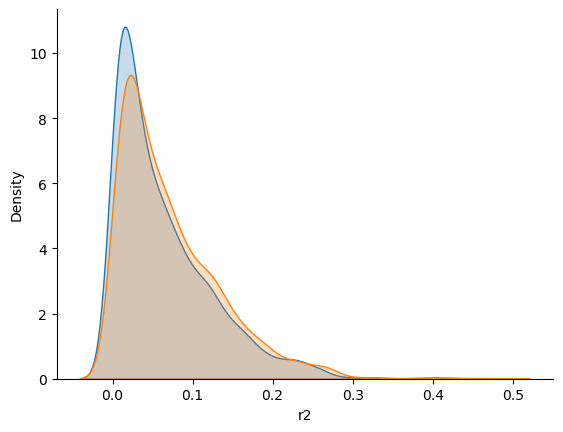

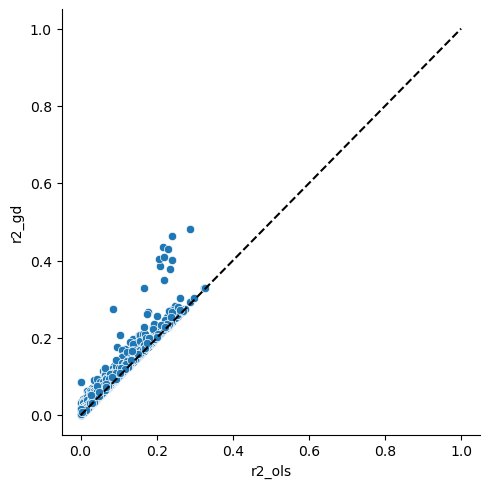

In [2]:
hrf_model = SPMHRFModel(tr)
model_gauss = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model, grid_coordinates=grid_coordinates)
par_fitter = ParameterFitter(model=model_gauss, data=d, paradigm=paradigm)
x = np.linspace(-8, 8, 10)
y = np.linspace(-4, 4, 10)
sd = np.linspace(0.1, 4, 10)


baseline = [0.0]
amplitude = [1.0]

pars_gauss_grid = par_fitter.fit_grid(x, y, sd, baseline, amplitude, correlation_cost=True)
pars_gauss_ols = par_fitter.refine_baseline_and_amplitude(pars_gauss_grid)
r2_gauss_ols = par_fitter.get_rsq(pars_gauss_ols)
sns.kdeplot(r2_gauss_ols, fill=True)
sns.despine()

pars_gauss_gd = par_fitter.fit(init_pars=pars_gauss_ols, max_n_iterations=1000)
r2_gauss_gd = par_fitter.get_rsq(pars_gauss_gd)
sns.kdeplot(r2_gauss_gd, fill=True)

r2 = pd.concat((r2_gauss_ols, r2_gauss_gd), keys=['r2_ols', 'r2_gd'], axis=1)
sns.relplot(x='r2_ols', y='r2_gd', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

*** Fitting: ***
 * x
 * y
 * sd
 * baseline
 * amplitude
 * hrf_delay
 * hrf_dispersion
Number of problematic voxels (mask): 57
Number of voxels remaining (mask): 2308


Current R2: 0.10726/Best R2: 0.10726: 100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


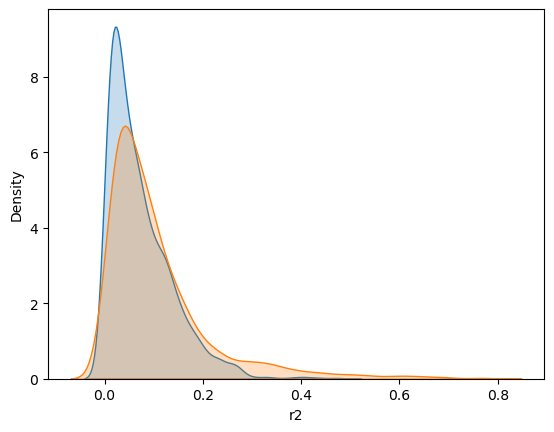

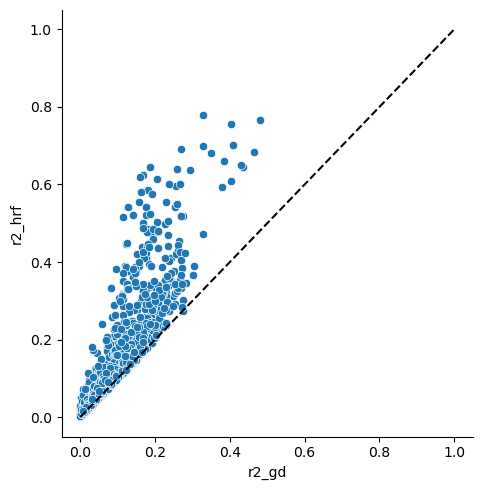

In [7]:

model_hrf = GaussianPRF2DWithHRF(data=d, paradigm=paradigm, hrf_model=hrf_model,
                             grid_coordinates=grid_coordinates, flexible_hrf_parameters=True)

par_fitter_hrf = ParameterFitter(model=model_hrf, data=d, paradigm=paradigm)

pars_gauss_gd['hrf_delay'] = 6.
pars_gauss_gd['hrf_dispersion'] = 1.

pars_gauss_hrf = par_fitter_hrf.fit(init_pars=pars_gauss_gd, max_n_iterations=1000, store_intermediate_parameters=True, learning_rate=0.01)
r2_gauss_hrf = par_fitter_hrf.get_rsq(pars_gauss_hrf)

sns.kdeplot(r2_gauss_gd, fill=True)
sns.kdeplot(r2_gauss_hrf, fill=True)

r2 = pd.concat((r2_gauss_gd, r2_gauss_hrf), keys=['r2_gd', 'r2_hrf'], axis=1)
sns.relplot(x='r2_gd', y='r2_hrf', data=r2.reset_index(), kind='scatter')
plt.plot([0, 1], [0, 1], 'k--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_19816/1381862822.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = pred.stack(['model', 'source']).to_frame('value')


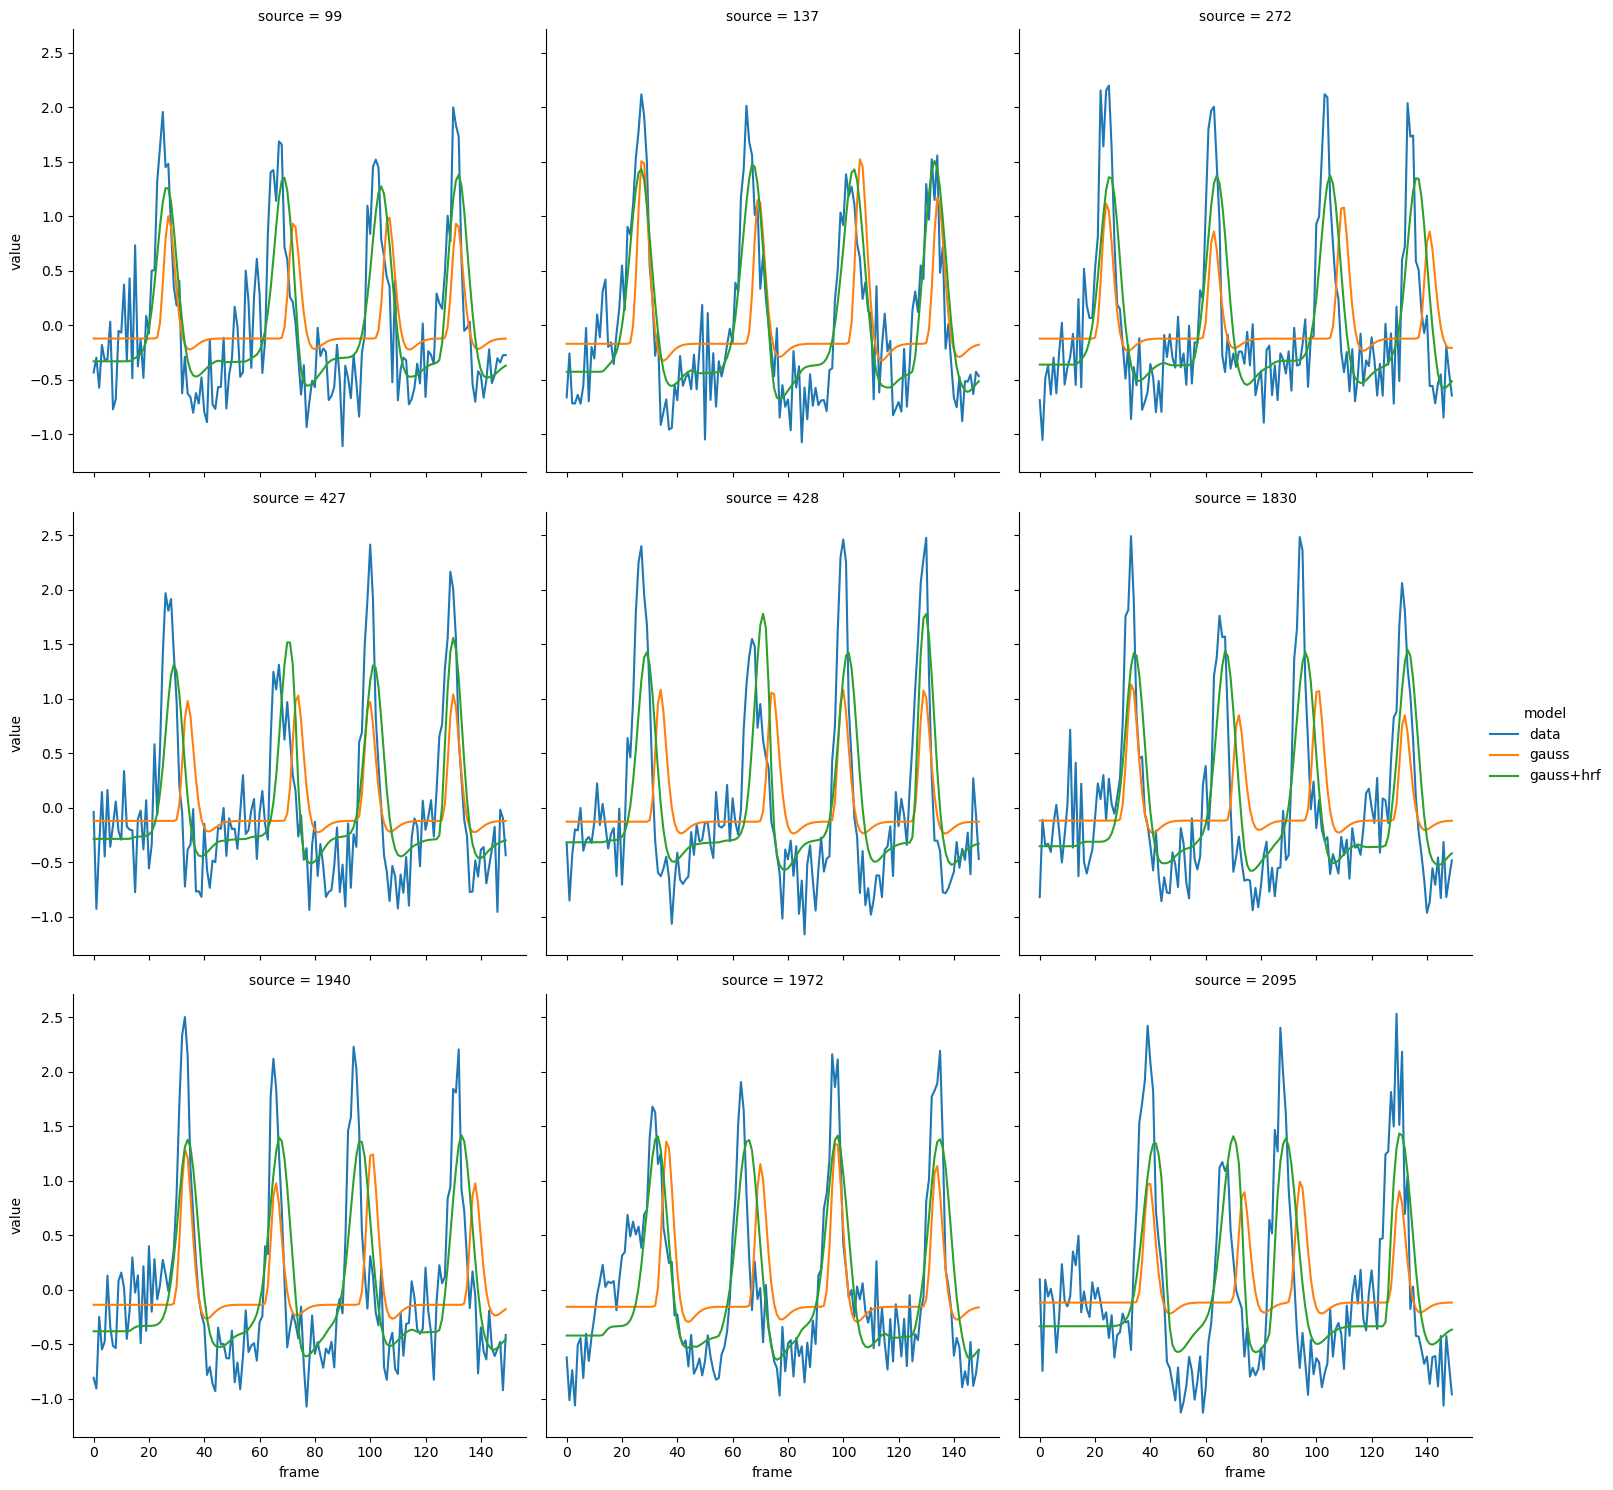

In [8]:
improvement = r2_gauss_hrf - r2_gauss_gd
largest_improvements = improvement.sort_values(ascending=False).index[:9]
pred_gauss_gd = model_gauss.predict(parameters=pars_gauss_gd)
pred_gauss_hrf = model_hrf.predict(parameters=pars_gauss_hrf)
pred = pd.concat((d.loc[:, largest_improvements], pred_gauss_gd.loc[:, largest_improvements], pred_gauss_hrf.loc[:, largest_improvements]), axis=1, keys=['data', 'gauss', 'gauss+hrf'], names=['model'])

#
tmp = pred.stack(['model', 'source']).to_frame('value')
sns.relplot(x='frame', y='value', hue='model', col='source', data=tmp.reset_index(), kind='line', col_wrap=3)

In [12]:
pars_gauss_hrf

parameter,x,y,sd,baseline,amplitude,hrf_delay,hrf_dispersion
source,,,,,,,
0,1.045999,1.632370,0.051101,-0.086976,0.510015,7.956218,0.550851
1,1.674410,0.651466,0.060599,-0.068241,0.762468,7.428112,0.507158
2,3.092115,0.536351,0.048301,-0.091201,1.041439,6.678134,0.687220
3,2.824387,0.284559,0.049275,-0.073116,0.353837,7.136093,0.642419
4,4.517866,0.311231,0.070699,-0.064812,0.822324,5.275713,0.623599
...,...,...,...,...,...,...,...
2360,1.364157,2.182667,0.072081,-0.029940,0.476915,6.906530,0.507608
2361,7.628022,1.775853,0.067092,-0.031301,0.531361,5.625261,0.514291
2362,-8.756128,0.853728,0.073055,-0.027207,0.369697,7.212814,0.505416


<Axes: xlabel='hrf_delay', ylabel='Count'>

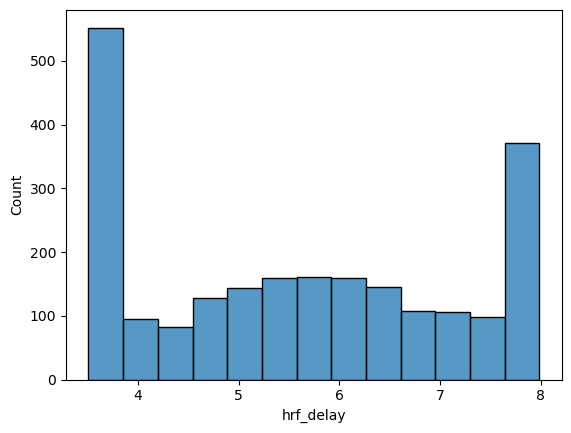

In [17]:
mask = pars_gauss_hrf['hrf_delay'] > 0.0
sns.histplot(pars_gauss_hrf[mask]['hrf_delay'])

<Axes: xlabel='hrf_dispersion', ylabel='Count'>

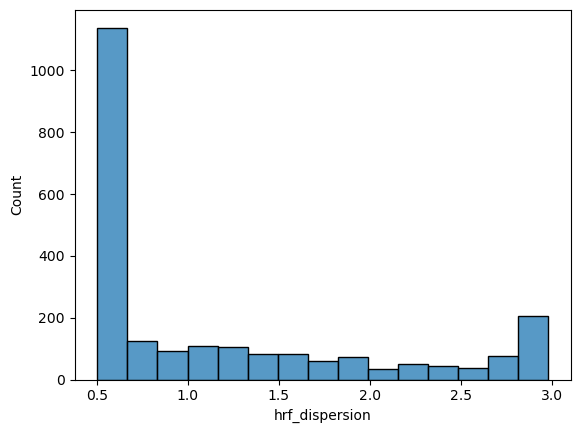

In [18]:
sns.histplot(pars_gauss_hrf[mask]['hrf_dispersion'])